In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, make_scorer, f1_score)
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import time

### 1. Data Loading

In [93]:
# Load the dataset
X_train_df = pd.read_csv('X_train.csv', header = 0) # Keep the first row, which are the titles
X_test_df = pd.read_csv('X_test.csv', header = 0)
X_train = X_train_df.values # Convert to numpy array
X_test = X_test_df.values
y_train = pd.read_csv('y_train.csv', header = 0).squeeze() # Extract Series from single-column DataFrame
y_test = pd.read_csv("y_test.csv", header = 0).squeeze()

# Save the list of feature names
feature_columns = X_train_df.columns.tolist 

### 2. Preprocessing

In [94]:
# Adjust the label to start from 0 to meet the requirement of XGBoost
min_label = min(y_train.min(), y_test.min())
if min_label > 0:
    y_train -= min_label
    y_test -= min_label
    print(f"Adjusted the label to start from 0: {np.unique(y_train)}")

# Standardize to improve the model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  

Adjusted the label to start from 0: [0 1 2 3 4 5]


### 3. Model Training

In [95]:
MODEL_CONFIG = {
    'LogisticRegression': {
        'class': LogisticRegression,
        'params': {'max_iter': 1000, 'class_weight': 'balanced'}
    },
    'RandomForest': {
        'class': RandomForestClassifier,
        'params': {'n_estimators': 200, 'max_depth': 10, 'class_weight': 'balanced'}
    },
    'SVM': {
        'class': SVC,
        'params': {'kernel': 'rbf', 'C': 1.0, 'class_weight': 'balanced'}
    },
    'XGBoost': {
        'class': XGBClassifier,
        'params': {'eval_metric': 'logloss'}
    }
}

def train_models(X_train, y_train):
    trained_models = {}
    for model_name, config in MODEL_CONFIG.items():
        print(f"\nTraining {model_name}...")
        start_time = time.time()
        
        # model initialization
        model = config['class'](**config['params'])
        
        # model training
        model.fit(X_train, y_train)
        
        # record the model date
        trained_models[model_name] = {
            'model': model,
            'train_time': time.time() - start_time,
            'feature_importances': getattr(model, 'feature_importances_', None)
        }
        
    return trained_models

trained_models = train_models(X_train_scaled, y_train)



Training LogisticRegression...

Training RandomForest...

Training SVM...

Training XGBoost...


### 4. Prediction and Evaluation
##### Visualize the confusion matrix, and calculate the accuracy/ precision/ recall/ f1 score for each model. 

<Figure size 600x600 with 0 Axes>

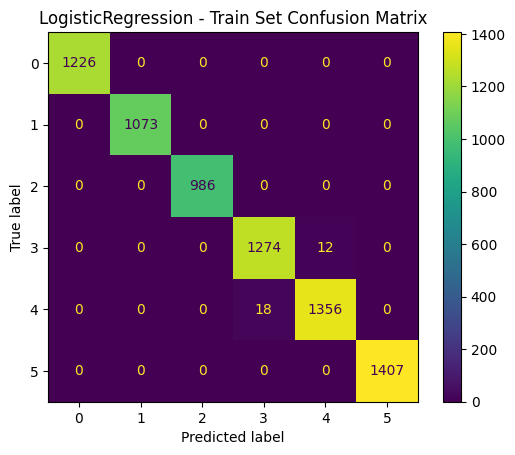

<Figure size 600x600 with 0 Axes>

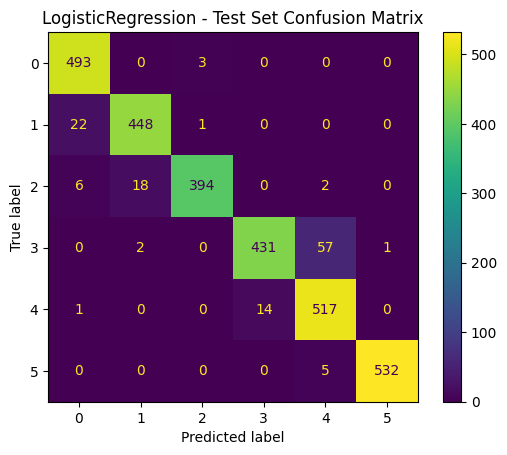

<Figure size 600x600 with 0 Axes>

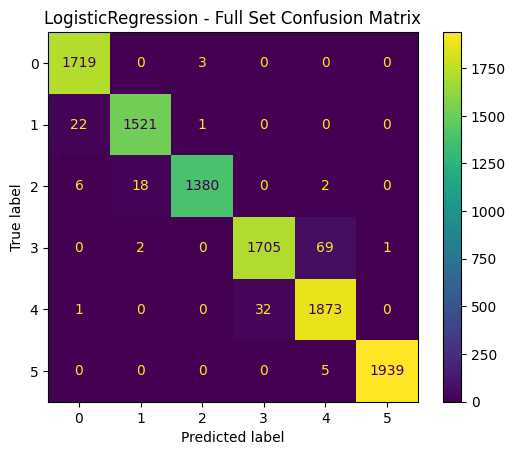

<Figure size 600x600 with 0 Axes>

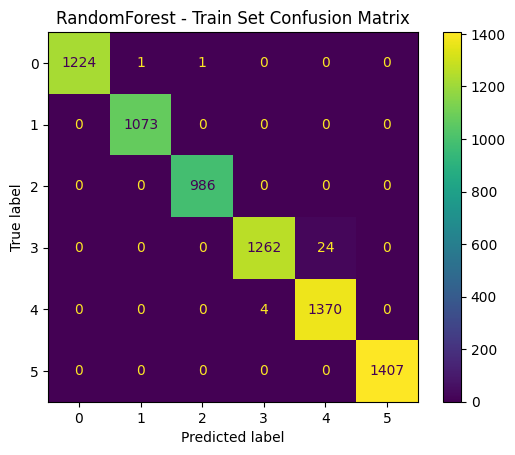

<Figure size 600x600 with 0 Axes>

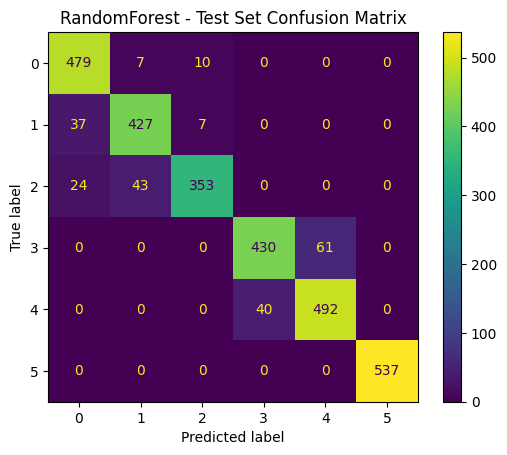

<Figure size 600x600 with 0 Axes>

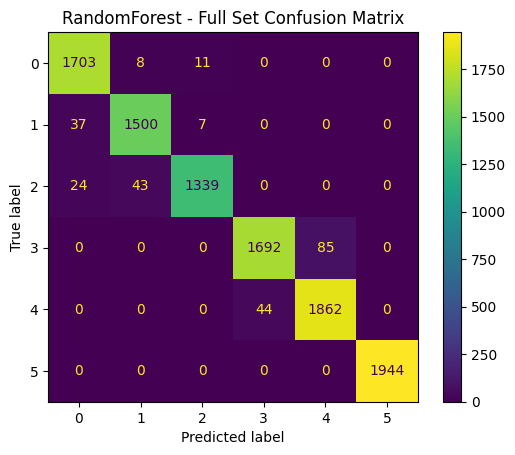

<Figure size 600x600 with 0 Axes>

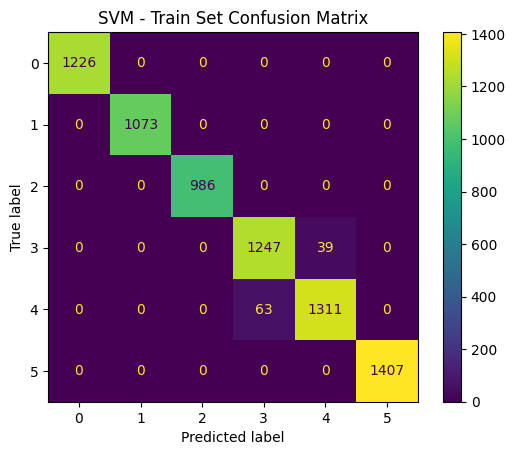

<Figure size 600x600 with 0 Axes>

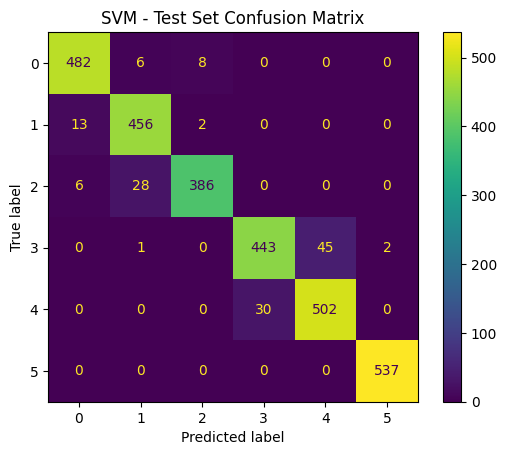

<Figure size 600x600 with 0 Axes>

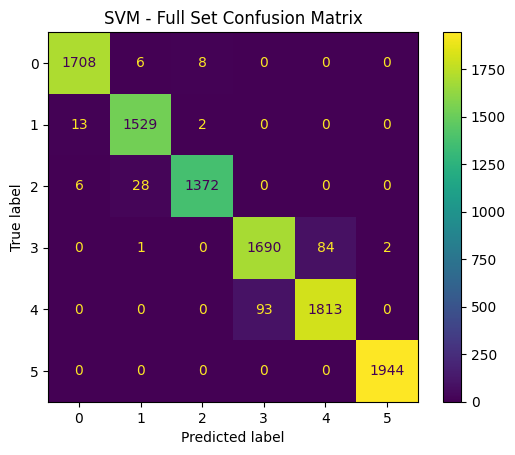

<Figure size 600x600 with 0 Axes>

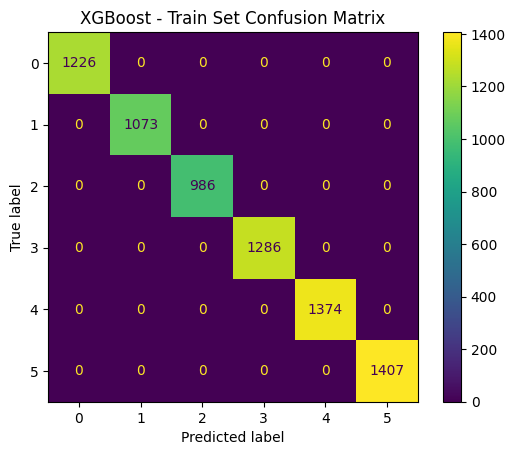

<Figure size 600x600 with 0 Axes>

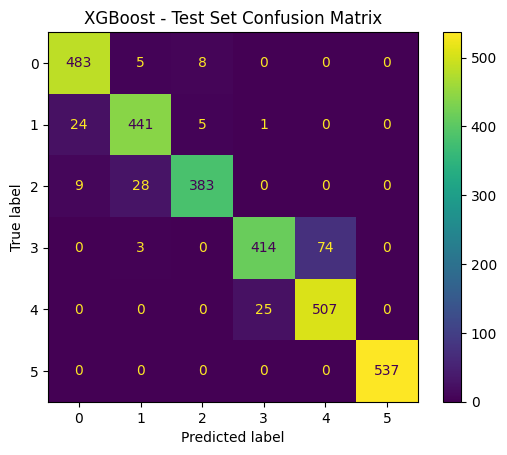

<Figure size 600x600 with 0 Axes>

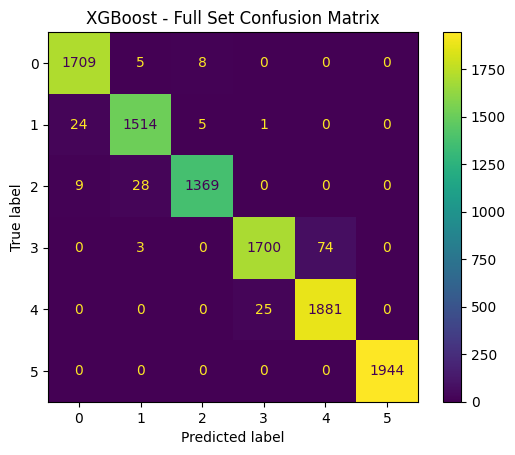


Model Performance Comparison:
                    Train Accuracy  Test Accuracy  Full Accuracy  \
LogisticRegression        0.995919       0.955209       0.984270   
RandomForest              0.995919       0.922294       0.974852   
SVM                       0.986126       0.952155       0.976405   
XGBoost                   1.000000       0.938242       0.982328   

                    Train Precision  Test Precision  Full Precision  \
LogisticRegression         0.995924        0.956918        0.984393   
RandomForest               0.995958        0.923594        0.975025   
SVM                        0.986189        0.952531        0.976429   
XGBoost                    1.000000        0.939658        0.982462   

                    Train Recall  Test Recall  Full Recall  Train F1  \
LogisticRegression      0.995919     0.955209     0.984270  0.995920   
RandomForest            0.995919     0.922294     0.974852  0.995918   
SVM                     0.986126     0.952155     0.9764

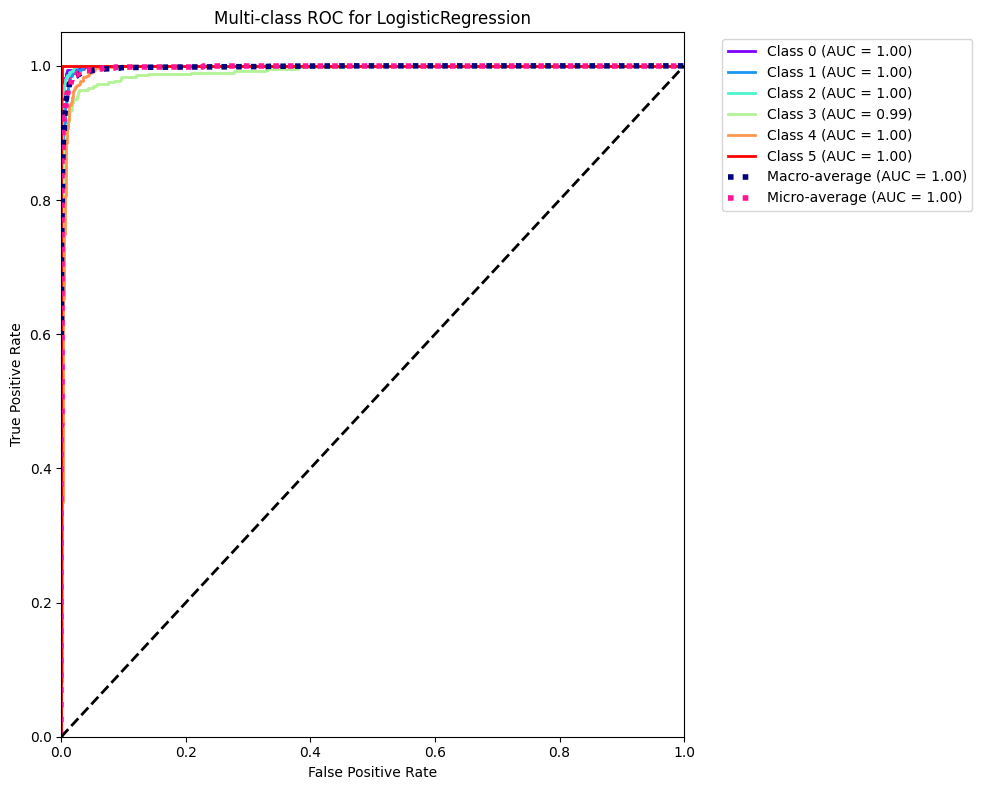


LogisticRegression AUC Summary:
  Class 0: 1.00
  Class 1: 1.00
  Class 2: 1.00
  Class 3: 0.99
  Class 4: 1.00
  Class 5: 1.00
  Macro-Average: 1.00
  Micro-Average: 1.00


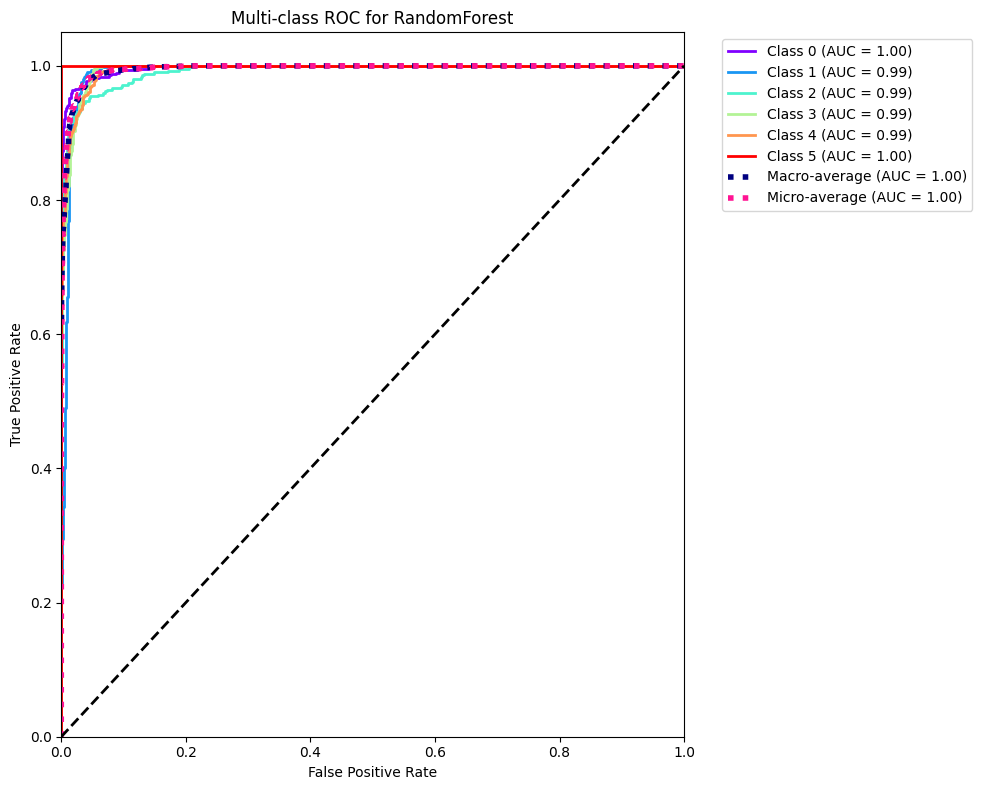


RandomForest AUC Summary:
  Class 0: 1.00
  Class 1: 0.99
  Class 2: 0.99
  Class 3: 0.99
  Class 4: 0.99
  Class 5: 1.00
  Macro-Average: 1.00
  Micro-Average: 1.00
Skipping ROC/AUC for SVM (no probability support)


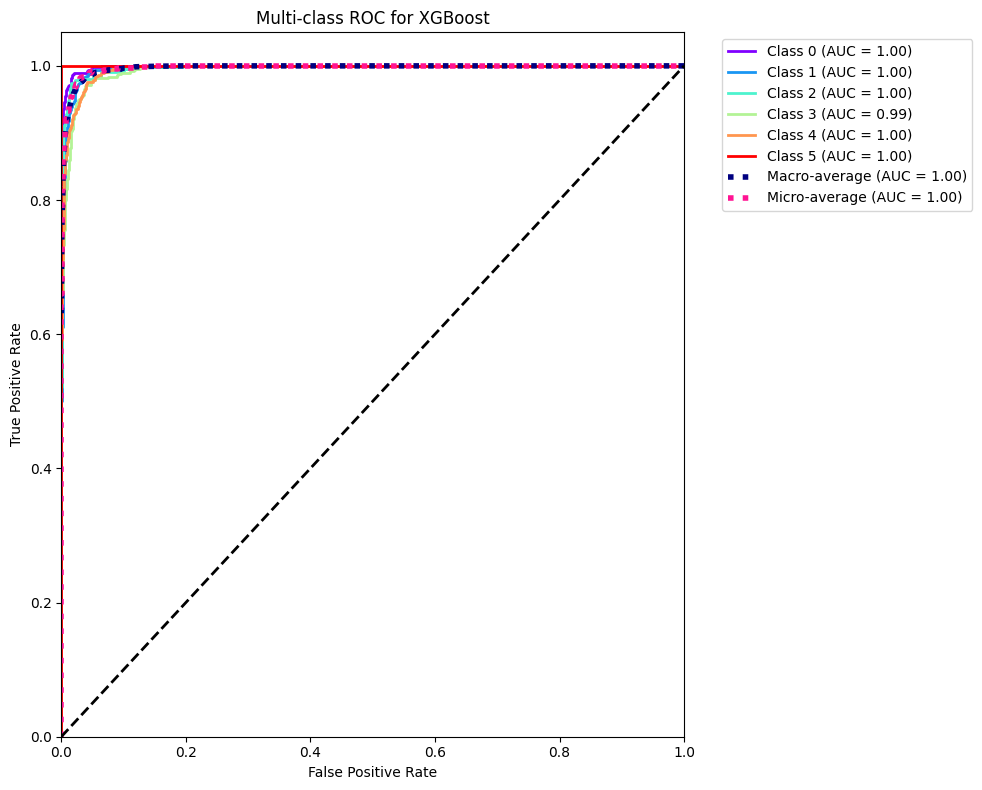


XGBoost AUC Summary:
  Class 0: 1.00
  Class 1: 1.00
  Class 2: 1.00
  Class 3: 0.99
  Class 4: 1.00
  Class 5: 1.00
  Macro-Average: 1.00
  Micro-Average: 1.00


In [96]:
def predict_all_sets(model, X_train, X_test):
    # Test the trained model on the training set, testing set and the entire set
    X_full = np.vstack([X_train, X_test])
    return {
        'train': model.predict(X_train),
        'test': model.predict(X_test),
        'full': model.predict(X_full)
    }

def evaluate_model(y_true, y_pred, dataset_name, model_name):
    # Generate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f'{model_name} - {dataset_name} Set Confusion Matrix')
    plt.show()
    
    return metrics

def compare_models(results):
    comparison = pd.DataFrame()
    for model_name, data in results.items():
        metrics = {
            'Train Accuracy': data['train']['accuracy'],
            'Test Accuracy': data['test']['accuracy'],
            'Full Accuracy': data['full']['accuracy'],
            'Train Precision': data['train']['precision'],
            'Test Precision': data['test']['precision'],
            'Full Precision': data['full']['precision'],
            'Train Recall': data['train']['recall'],
            'Test Recall': data['test']['recall'],
            'Full Recall': data['full']['recall'],
            'Train F1': data['train']['f1'],
            'Test F1': data['test']['f1'],
            'Full F1': data['full']['f1']            
        }
        comparison[model_name] = pd.Series(metrics)
    return comparison.T

# Prediction and evaluation flow
results = {}
for model_name, model_data in trained_models.items():
    # Get predictions using scaled data
    preds = predict_all_sets(model_data['model'], X_train_scaled, X_test_scaled)
    
    # Create full dataset labels
    y_full = np.concatenate([y_train, y_test])
    
    # Evaluate all sets with visualization
    results[model_name] = {
        'train': evaluate_model(y_train, preds['train'], 'Train', model_name),
        'test': evaluate_model(y_test, preds['test'], 'Test', model_name),
        'full': evaluate_model(y_full, preds['full'], 'Full', model_name)
    }

# Generate comparison table with full set metrics
comparison_table = compare_models(results)
print("\nModel Performance Comparison:")
print(comparison_table)

# ROC and AUC
# Modify SVM configuration to enable probability estimates
MODEL_CONFIG['SVM']['params']['probability'] = True

# Function to plot ROC curves and compute AUC for each model
def plot_roc_and_calculate_auc(trained_models, X_test_scaled, y_test):
    for model_name, model_data in trained_models.items():
        model = model_data['model']
        
        # Skip models without probability estimates
        if not hasattr(model, 'predict_proba'):
            print(f"Skipping ROC/AUC for {model_name} (no probability support)")
            continue

        # Get model's class information
        model_classes = model.classes_
        n_classes = len(model_classes)
        
        # Binarize test labels according to model's classes
        y_test_bin = label_binarize(y_test, classes=model_classes)
        
        # Get predicted probabilities
        y_prob = model.predict_proba(X_test_scaled)
        
        # Initialize structures for ROC/AUC
        fpr, tpr, roc_auc = {}, {}, {}
        
        # Calculate metrics per class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute macro-average
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        # Compute micro-average
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Visualization
        plt.figure(figsize=(10, 8))
        colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
        
        # Plot individual classes
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'Class {model_classes[i]} (AUC = {roc_auc[i]:.2f})')
        
        # Plot averages
        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
                 color='navy', linestyle=':', linewidth=4)
        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
                 color='deeppink', linestyle=':', linewidth=4)
        
        # Formatting
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multi-class ROC for {model_name}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # Print metrics
        print(f"\n{model_name} AUC Summary:")
        for i in range(n_classes):
            print(f"  Class {model_classes[i]}: {roc_auc[i]:.2f}")
        print(f"  Macro-Average: {roc_auc['macro']:.2f}")
        print(f"  Micro-Average: {roc_auc['micro']:.2f}")

# Execute ROC/AUC analysis
plot_roc_and_calculate_auc(trained_models, X_test_scaled, y_test)

### 5. Visualization


Generating Visualizations...


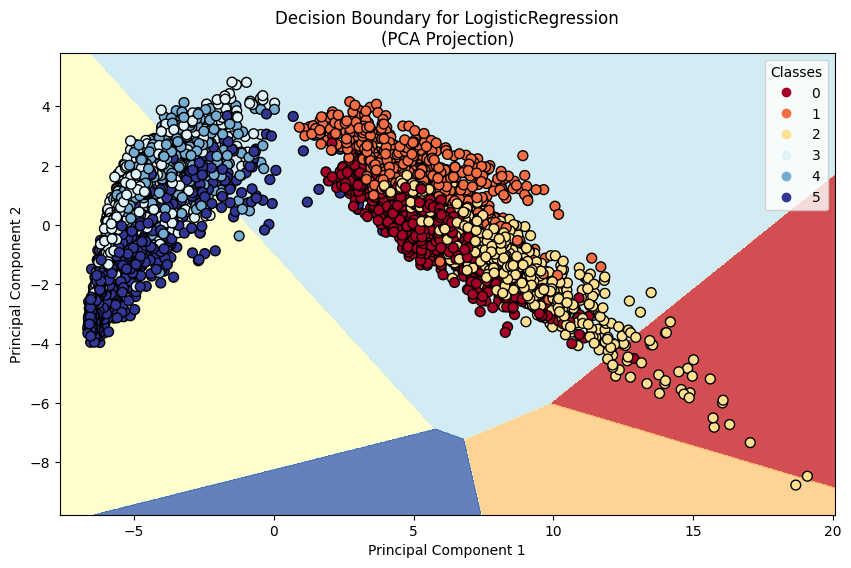

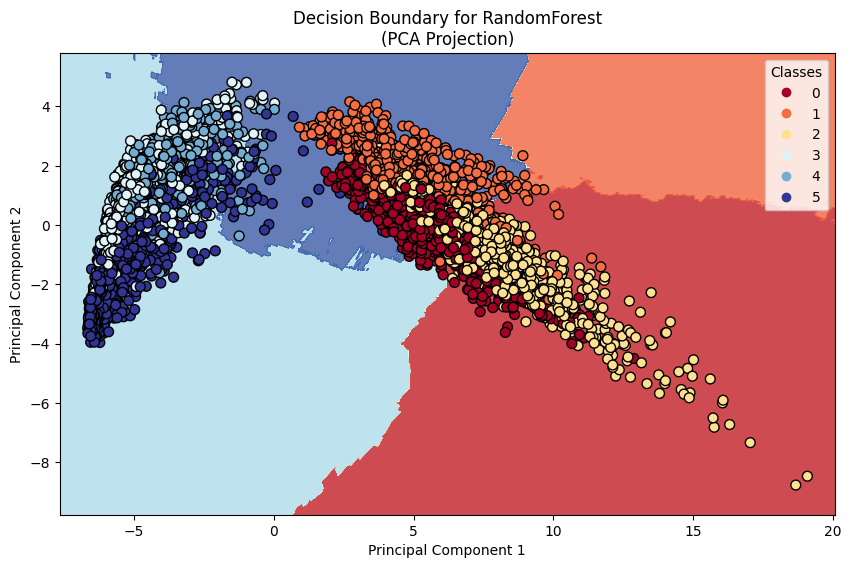

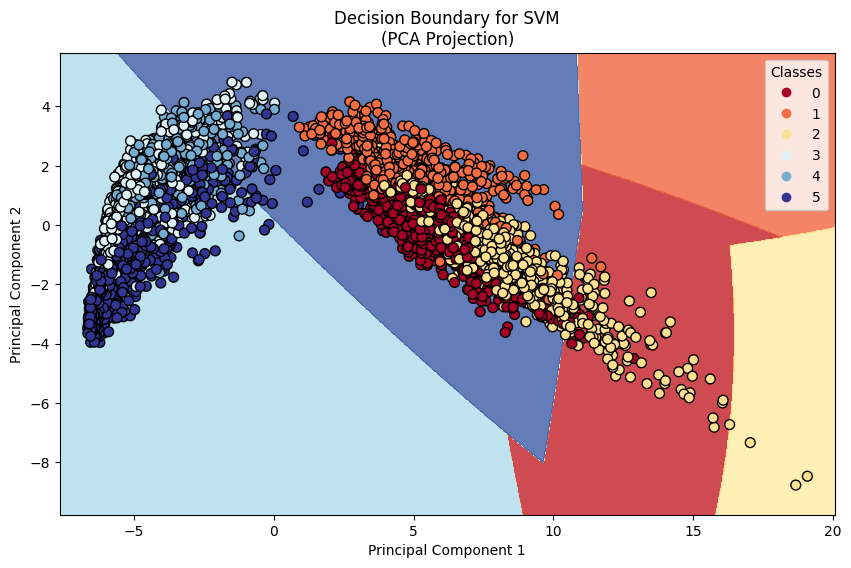

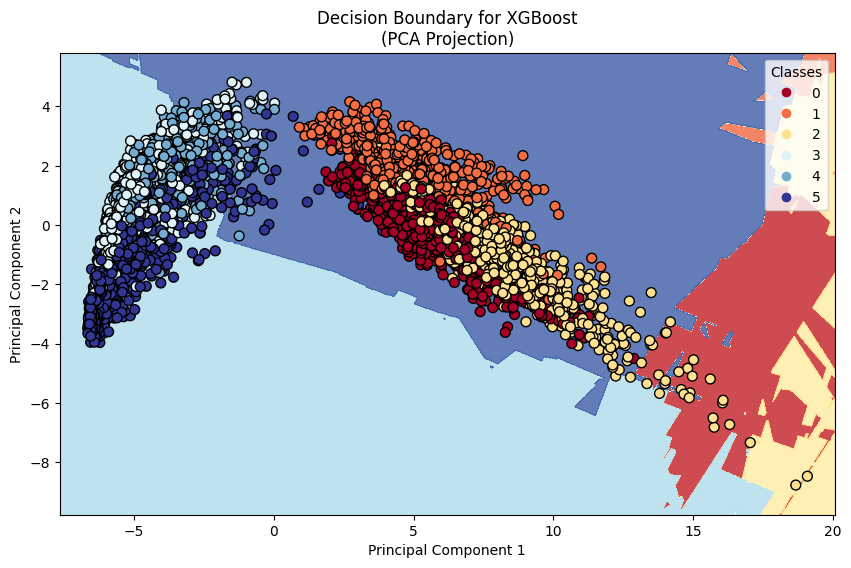

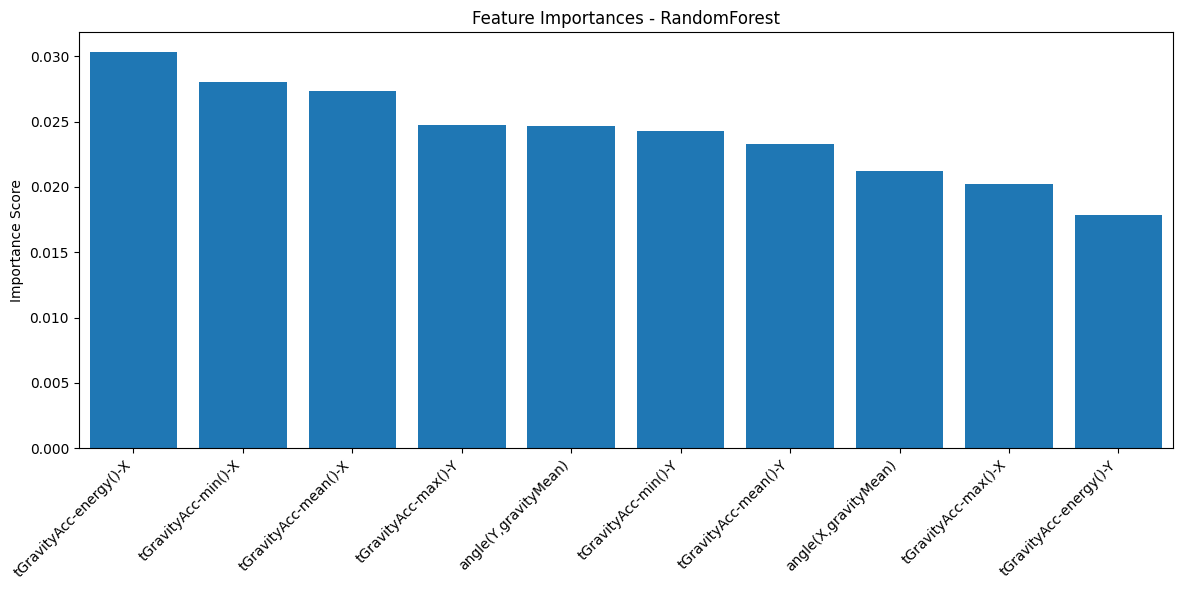

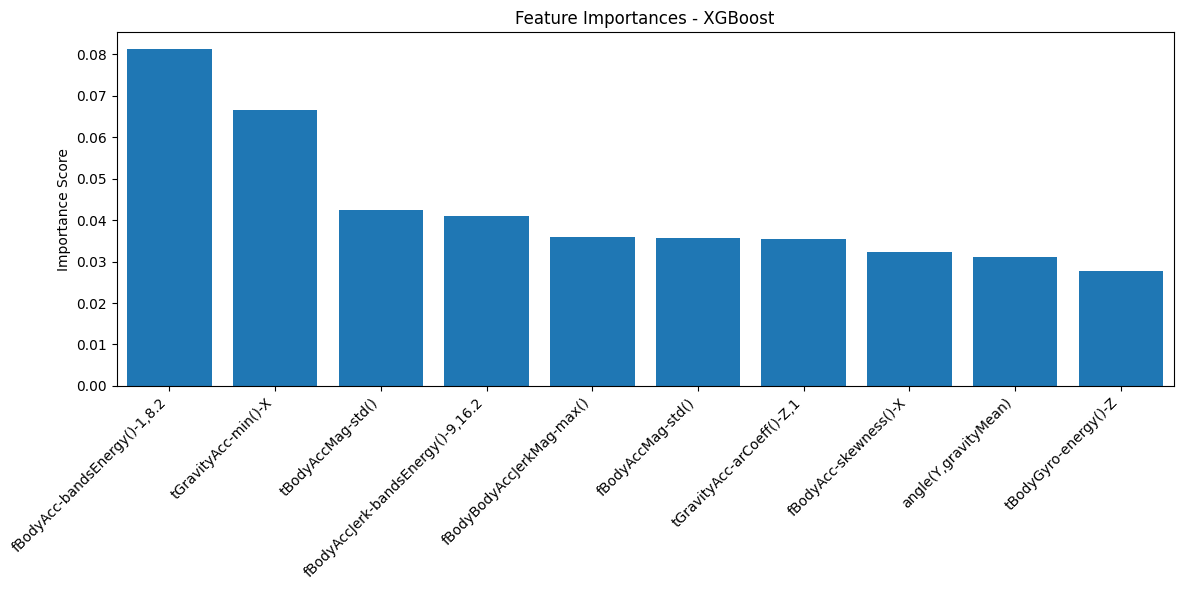

In [97]:
# Fix feature_columns definition (correct the typo)
feature_columns = X_train_df.columns.tolist()

# Visualize Decision Boundaries using PCA
def plot_decision_boundaries(trained_models, X_train, X_test, y_train):
    # Combine train and test for full PCA fit
    X_full = np.vstack([X_train, X_test])
    pca = PCA(n_components=2)
    pca.fit(X_full)
    
    # Transform both train and test
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Create mesh grid
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    for model_name, model_data in trained_models.items():
        model = model_data['model']
        plt.figure(figsize=(10, 6))
        
        # Predict on PCA meshgrid
        Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
        
        # Plot training data points
        scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, 
                              edgecolor='k', cmap=plt.cm.RdYlBu, s=50)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(f'Decision Boundary for {model_name}\n(PCA Projection)')
        plt.legend(*scatter.legend_elements(), title='Classes')
        plt.show()

# Visualize Feature Importances
def plot_feature_importances(trained_models, feature_columns):
    for model_name, model_data in trained_models.items():
        importances = model_data['feature_importances']
        if importances is not None:
            plt.figure(figsize=(12, 6))
            indices = np.argsort(importances)[::-1][:10]  # Top 10 features
            plt.title(f"Feature Importances - {model_name}")
            plt.bar(range(len(indices)), importances[indices], align='center')
            plt.xticks(range(len(indices)), [feature_columns[i] for i in indices], 
                       rotation=45, ha='right')
            plt.xlim([-0.5, len(indices)-0.5])
            plt.ylabel("Importance Score")
            plt.tight_layout()
            plt.show()

# Execute visualization functions
print("\nGenerating Visualizations...")
plot_decision_boundaries(trained_models, X_train, X_test, y_train)
plot_feature_importances(trained_models, feature_columns)\



### 6. Model Improvement


=== Optimizing LogisticRegression ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits


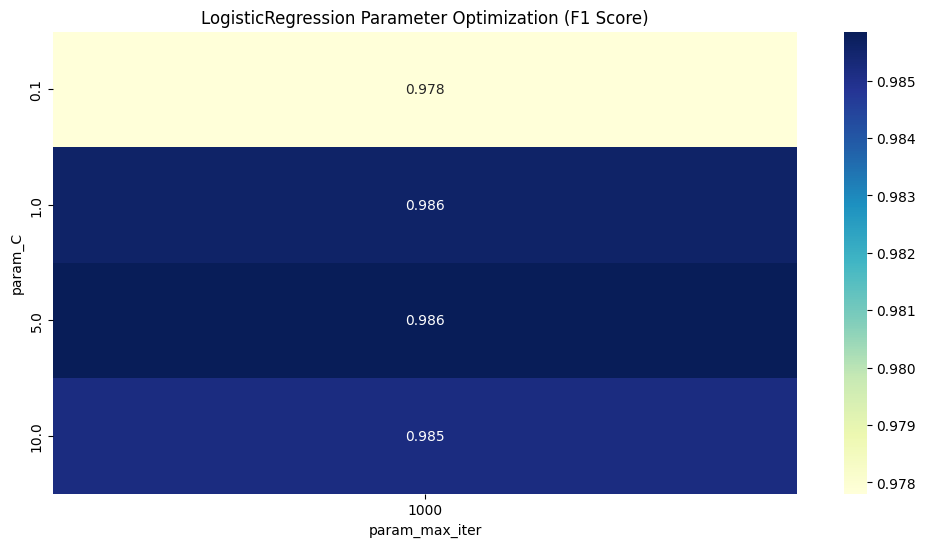


Optimal parameters: 
C: 5
max_iter: 1000
solver: sag
Best f1 score in validation set: 0.9861

=== Optimizing RandomForest ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits


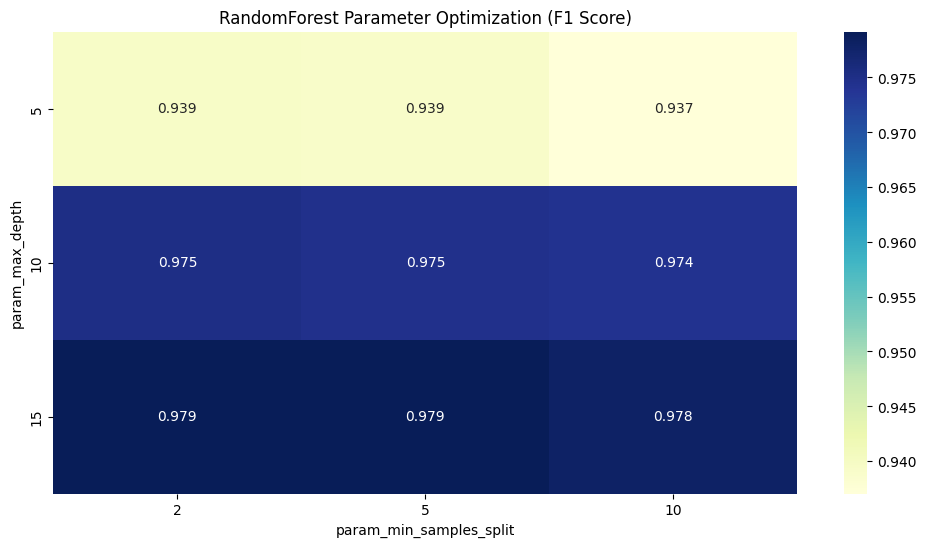


Optimal parameters: 
max_depth: None
min_samples_split: 2
n_estimators: 100
Best f1 score in validation set: 0.9808

=== Optimizing SVM ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits


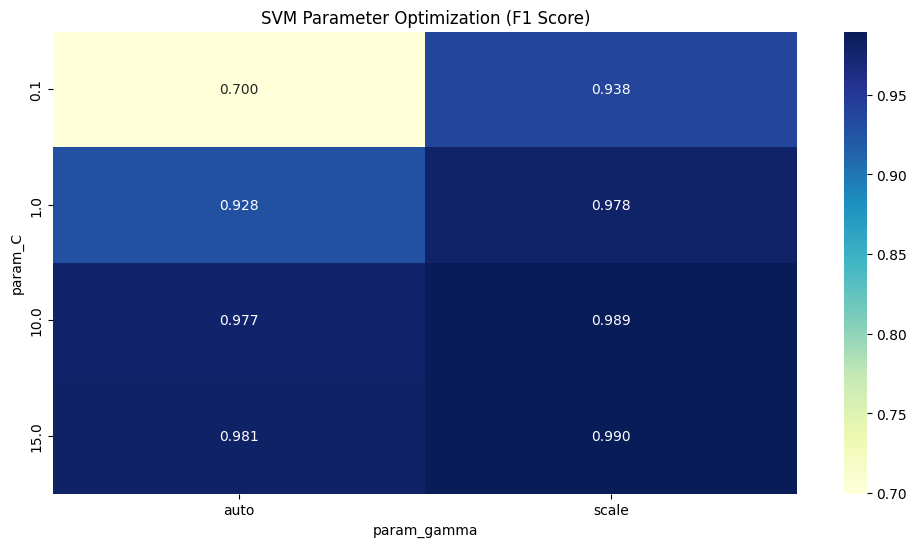


Optimal parameters: 
C: 15
gamma: scale
kernel: poly
Best f1 score in validation set: 0.9903

=== Optimizing XGBoost ===
Fitting 5 folds for each of 18 candidates, totalling 90 fits


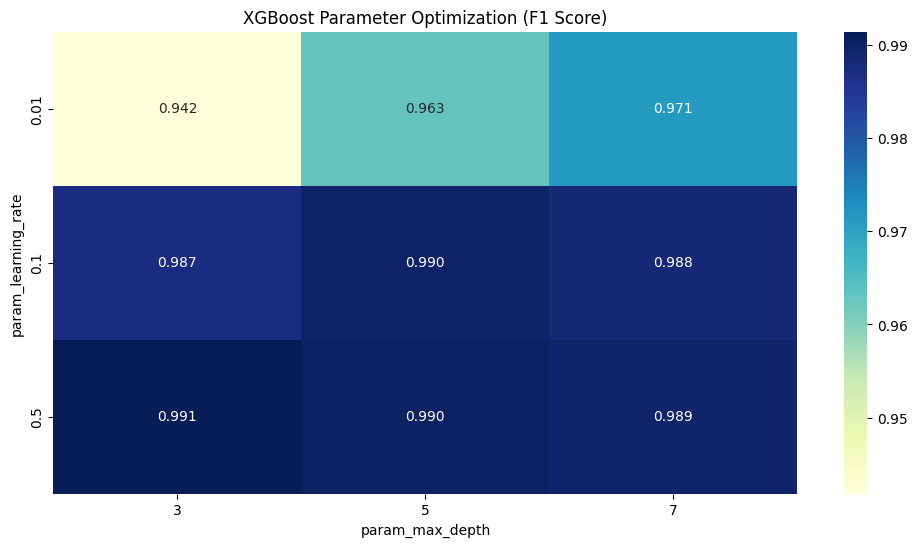


Optimal parameters: 
learning_rate: 0.5
max_depth: 3
subsample: 1.0
Best f1 score in validation set: 0.9918


In [101]:


# 定义网格搜索参数空间
MODEL_CONFIG = {
    'LogisticRegression': {
        'class': LogisticRegression,
        'params': {
            'max_iter': [1000],
            'solver': ['lbfgs', 'sag'],
            'C': [0.1, 1, 5, 10]
        }
    },
    'RandomForest': {
        'class': RandomForestClassifier,
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10]
        }
    },
    'SVM': {
        'class': SVC,
        'params': {
            'C': [0.1, 1, 10, 15],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf', 'poly']
        }
    },
    'XGBoost': {
        'class': XGBClassifier,
        'params': {
            'learning_rate': [0.01, 0.1, 0.5],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    }
}

def plot_grid_search_results(model_data, model_name):
    results = model_data['cv_results']
    
    # 提取关键参数
    params = [p for p in results.columns if p.startswith('param_')]
    top_params = results.loc[results['rank_test_f1'] <= 3, params].iloc[0]
    
    # 创建热力图
    plt.figure(figsize=(12, 6))
    heatmap_data = results.pivot_table(
        index=params[0], 
        columns=params[1] if len(params)>1 else 'param_C',
        values='mean_test_f1'
    )
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title(f'{model_name} Parameter Optimization (F1 Score)')
    plt.show()
    
    # 显示最佳参数
    print(f"\nOptimal parameters: ")
    for param, value in model_data['best_params'].items():
        print(f"{param}: {value}")
    print(f"Best f1 score in validation set: {model_data['best_score']:.4f}")
    
def improve_models_via_gridsearch(trained_models, MODEL_CONFIG, X_train, y_train):
    """使用网格搜索优化模型并可视化结果"""
    improved_models = {}
    scoring = {
        'f1': make_scorer(f1_score, average='weighted'),
        'accuracy': 'accuracy'
    }
    
    for model_name in trained_models:
        print(f"\n=== Optimizing {model_name} ===")
        start_time = time.time()
        
        # 获取参数空间和模型类
        param_grid = MODEL_CONFIG[model_name]['params']
        model_class = MODEL_CONFIG[model_name]['class']
        
        # 配置网格搜索
        grid = GridSearchCV(
            estimator=model_class(),
            param_grid=param_grid,
            scoring=scoring,
            refit='f1',
            cv=StratifiedKFold(n_splits=5, shuffle=True),
            n_jobs=-1,
            verbose=1
        )
        
        # 执行搜索
        grid.fit(X_train, y_train)
        
        # 保存结果
        improved_models[model_name] = {
            'best_model': grid.best_estimator_,
            'best_params': grid.best_params_,
            'best_score': grid.best_score_,
            'cv_results': pd.DataFrame(grid.cv_results_),
            'search_time': time.time() - start_time
        }
        
        # 可视化参数影响
        plot_grid_search_results(improved_models[model_name], model_name)
        
    return improved_models

# 初始化基准模型
base_models = {name: config['class'](**config['params']) 
                for name, config in MODEL_CONFIG.items()}
    
# 优化模型
improved_models = improve_models_via_gridsearch(base_models, MODEL_CONFIG, X_train, y_train)
    
# 保存最佳模型
for name, data in improved_models.items():
    joblib.dump(data['best_model'], f'best_{name}.pkl')